# Clase Práctica 4: Clustering

El clustering o agrupamiento es la tarea de agrupar una serie de objetos de una manera que objetos del mismo grupo (cluster) son más similares entre sí que con los de otros grupos. Su objetivo principal es en la fase exploratoria de los datos y se clasifica dentro de los métodos no supervisados de aprendizaje de máquinas.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.cluster # Algoritmos de clustering
import sklearn.metrics
import scipy.cluster
import seaborn as sns

In [2]:
blobs = pd.read_csv("https://raw.githubusercontent.com/fvillena/biocompu/2022/data/blobs.csv") # Importamos un csv que contiene los datos a analizar

In [3]:
blobs.head() # Verificamos qué podemos encontrar en el conjunto de datos.

,x,y
0,-7.028929,6.461681
1,7.918778,1.532250
2,7.715440,-1.071657
3,-6.947604,7.059319
4,8.229129,5.251265


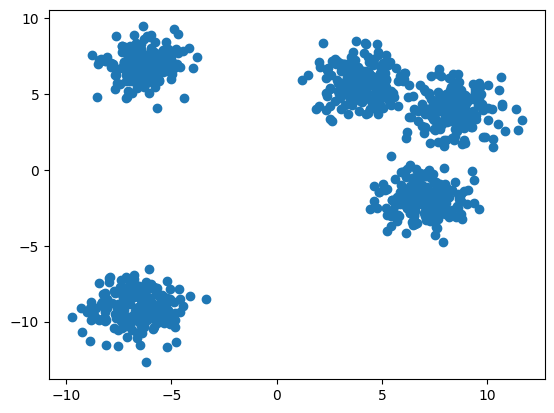

In [4]:
plt.scatter(blobs.x, blobs.y) # Exploramos la distribución que tienen nuestros datos

Intuitivamente podemos desprender que existe cierto agrupamiento de los datos. Uno de los algoritmos para realizar clustering es el k-means que se encuentra implementado en la clase sklearn.cluster.KMeans. Procederemos a realizar un agrupamiento utilizando este algoritmo.

k-Means necesita que nosotros asignemos el hiperparámetro de la cantidad de grupos a ajustar, comenzaremos con 2 grupos.

Ajustamos un modelo de k-means.

In [5]:
km = sklearn.cluster.KMeans(n_clusters=2, random_state=11) # Instanciamos el algoritmo de k-means
km.fit(blobs) # Ajustamos el modelo de k-means

/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=11)

In [6]:
km.labels_ # Grupos a los cuales asoció el modelo a cada una de las instancias del conjunto de datos

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,

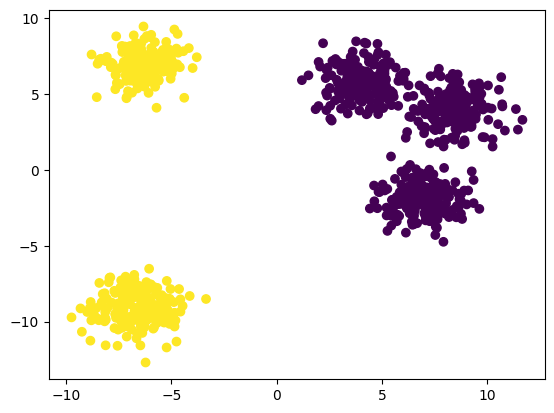

In [7]:
plt.scatter(blobs.x, blobs.y, c = km.labels_) # Verificamos gráficamente el agrupamiento

Utilizaremos el método del codo para intentar encontrar la cantidad de grupos óptima en nuestro conjunto de datos.

El método del codo busca encontrar la cantidad óptima de grupos al iterar por un rango de cantidad de grupos para encontrar dónde se genera un cambio en la pendiente de la curva de dispersión de los grupos contra la cantidad de grupos.

In [8]:
inertias = []
n_clusters_iterable = range(1,10)
for n_clusters in n_clusters_iterable:
    km = sklearn.cluster.KMeans(n_clusters=n_clusters) # Instanciamos el algoritmo de k-means
    km.fit(blobs) # Ajustamos el modelo de k-means
    inertias.append(km.inertia_) # Esta la dispersión de nuestros grupos

/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

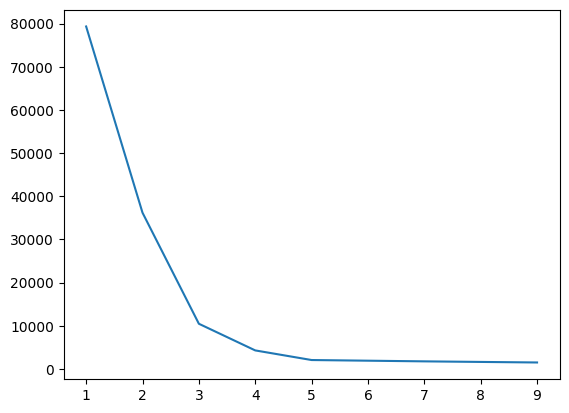

In [9]:
plt.plot(
    n_clusters_iterable,
    inertias
)

Otro método de optimización de la cantidad de grupos es el método de la silueta, en donde se busca maximizar el silhouette score al modular el número de clusters.

El silhouette score es un promedio de las siluetas de cada punto. Cada silueta se calcula usando la distancia intra-cluster promedio $a$ y la distancia promedio al cluster más cercano $b$, por lo tanto el valor de la silueta es:

$\frac{b-a}{max(a,b)}$

In [10]:
silhouette_scores = []
n_clusters_iterable = range(2,10)
for n_clusters in n_clusters_iterable:
    km = sklearn.cluster.KMeans(n_clusters=n_clusters) # Instanciamos el algoritmo de k-means
    km.fit(blobs) # Ajustamos el modelo de k-means
    silhouette_scores.append(sklearn.metrics.silhouette_score(blobs, km.labels_)) # Esta la dispersión de nuestros grupos

/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' 

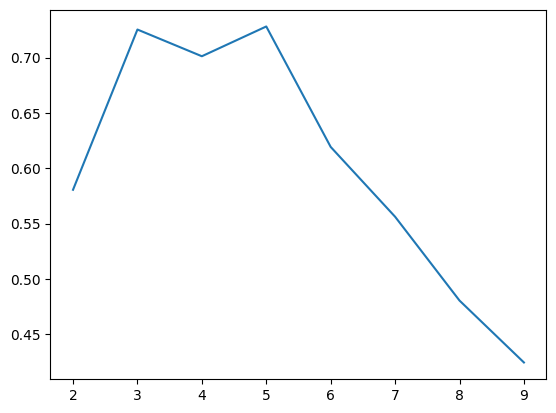

In [11]:
plt.plot(
    n_clusters_iterable,
    silhouette_scores
)

Según los análisis anteriores podemos desprender que alrededor de 5 grupos sería un hiperparámetro óptimo para nuestro modelamiento.

In [12]:
km_tuned = sklearn.cluster.KMeans(n_clusters=5, random_state=11) # Instanciamos el algoritmo de k-means
km_tuned.fit(blobs) # Ajustamos el modelo de k-means

/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=11)

In [13]:
km_tuned.labels_ # Grupos a los cuales asoció el modelo a cada una de las instancias del conjunto de datos

array([1, 4, 3, 1, 4, 2, 4, 0, 4, 2, 1, 0, 0, 3, 1, 4, 3, 1, 1, 0, 2, 1,
       1, 2, 4, 2, 0, 3, 4, 1, 4, 2, 1, 3, 2, 3, 1, 3, 4, 4, 3, 4, 1, 2,
       0, 1, 1, 2, 4, 0, 3, 4, 4, 3, 1, 1, 0, 3, 3, 3, 2, 4, 0, 3, 1, 2,
       3, 3, 3, 2, 3, 2, 1, 3, 1, 4, 3, 3, 0, 4, 0, 4, 2, 3, 3, 0, 0, 4,
       1, 1, 3, 0, 1, 1, 4, 0, 1, 0, 3, 3, 3, 3, 2, 3, 4, 2, 2, 0, 2, 3,
       2, 3, 3, 2, 1, 3, 2, 2, 4, 3, 4, 2, 2, 4, 1, 0, 3, 3, 1, 1, 0, 2,
       3, 4, 1, 2, 4, 4, 4, 4, 0, 3, 4, 1, 2, 3, 4, 0, 0, 1, 0, 2, 2, 4,
       3, 1, 4, 0, 1, 3, 0, 3, 3, 4, 2, 0, 0, 4, 1, 2, 4, 3, 1, 4, 1, 2,
       4, 1, 3, 2, 0, 3, 3, 3, 2, 2, 0, 2, 1, 0, 4, 4, 2, 3, 2, 4, 3, 3,
       4, 2, 4, 3, 2, 2, 0, 1, 3, 2, 4, 3, 2, 0, 0, 4, 3, 3, 0, 0, 0, 2,
       0, 1, 4, 3, 2, 0, 0, 4, 4, 2, 1, 3, 4, 3, 4, 4, 4, 4, 1, 3, 2, 0,
       4, 3, 4, 3, 4, 3, 2, 2, 3, 4, 3, 2, 3, 4, 4, 2, 3, 0, 3, 3, 2, 2,
       0, 0, 4, 2, 4, 4, 1, 2, 0, 1, 0, 0, 1, 3, 1, 0, 1, 4, 4, 2, 1, 1,
       4, 2, 0, 0, 3, 4, 0, 2, 1, 2, 3, 2, 0, 1, 4,

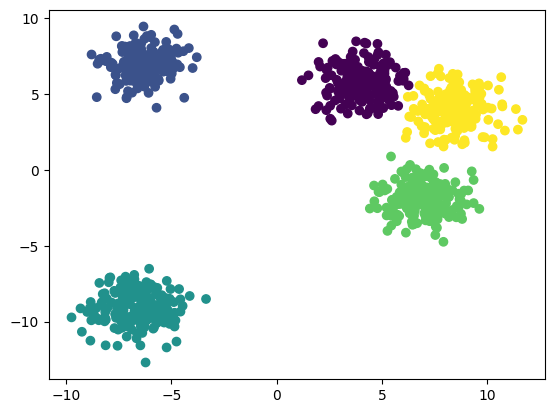

In [14]:
plt.scatter(blobs.x, blobs.y, c = km_tuned.labels_) # Verificamos gráficamente el agrupamiento

# Clustering jerárquico

Para explorar el funcionamiento del clustering jerárquico utilizaremos un conjunto de datos en donde los grupos no tienen una configuración circular.

In [15]:
moons = pd.read_csv("https://raw.githubusercontent.com/fvillena/biocompu/2022/data/twomoons.csv")

In [16]:
moons.head()

,x,y
0,1.725508,-0.043207
1,-0.826517,0.559084
2,1.964777,0.217817
3,1.453529,-0.398344
4,0.030248,0.465012


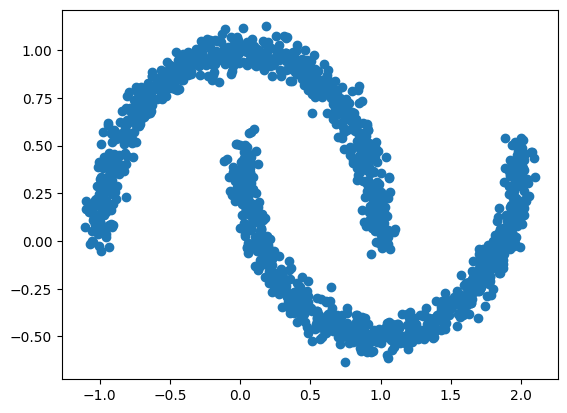

In [17]:
plt.scatter(moons.x, moons.y)

Ajustamos un modelo de k-means para demostrar que el comportamiento de este modelo no es el más correcto.

In [18]:
km_moons = sklearn.cluster.KMeans(n_clusters=2, random_state=11)
km_moons.fit(moons)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=11)

In [19]:
km.labels_

array([2, 4, 3, 2, 8, 6, 8, 0, 4, 1, 2, 5, 0, 7, 2, 4, 3, 2, 2, 5, 1, 2,
       2, 1, 8, 6, 0, 3, 8, 2, 8, 1, 2, 7, 1, 7, 2, 3, 8, 4, 3, 4, 2, 6,
       0, 2, 2, 6, 8, 5, 7, 4, 8, 7, 2, 2, 0, 3, 7, 3, 6, 4, 5, 3, 2, 1,
       3, 3, 7, 1, 3, 1, 2, 7, 2, 4, 3, 3, 5, 4, 0, 4, 6, 3, 3, 5, 5, 4,
       2, 2, 7, 5, 2, 2, 8, 5, 2, 5, 7, 7, 7, 7, 1, 3, 8, 1, 1, 5, 6, 3,
       6, 7, 7, 1, 2, 3, 1, 6, 4, 3, 4, 1, 1, 4, 2, 0, 3, 3, 2, 2, 5, 1,
       7, 4, 2, 1, 4, 8, 8, 4, 5, 3, 4, 2, 6, 7, 4, 0, 0, 2, 5, 1, 1, 8,
       3, 2, 8, 5, 2, 7, 5, 3, 3, 4, 6, 5, 0, 4, 2, 1, 8, 7, 2, 8, 2, 6,
       8, 2, 3, 1, 0, 7, 3, 3, 1, 1, 0, 1, 2, 0, 4, 4, 1, 3, 1, 8, 7, 7,
       8, 1, 8, 7, 1, 1, 0, 2, 7, 6, 8, 3, 1, 0, 0, 8, 3, 3, 5, 0, 0, 1,
       5, 2, 8, 3, 6, 5, 5, 4, 8, 1, 2, 7, 8, 3, 8, 8, 4, 4, 2, 3, 6, 5,
       8, 3, 8, 3, 8, 7, 1, 1, 3, 4, 7, 6, 3, 8, 8, 1, 3, 5, 7, 7, 1, 1,
       5, 5, 4, 1, 8, 8, 2, 6, 0, 2, 5, 5, 2, 3, 2, 0, 2, 4, 8, 1, 2, 2,
       8, 1, 5, 5, 7, 4, 0, 1, 2, 6, 7, 6, 0, 2, 8,

Observamos que el agrupamiento que se realizó con k-means no se ajusta a nuestro conjunto de datos.

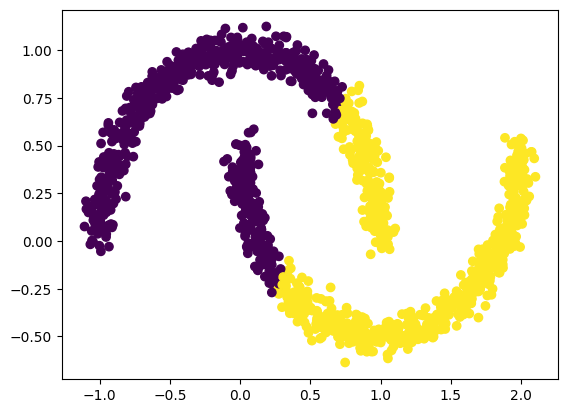

In [20]:
plt.scatter(moons.x, moons.y, c = km_moons.labels_)

Ajustamos un modelo de clustering jerárquico.

In [21]:
ac = sklearn.cluster.AgglomerativeClustering()
ac.fit(moons)

AgglomerativeClustering()

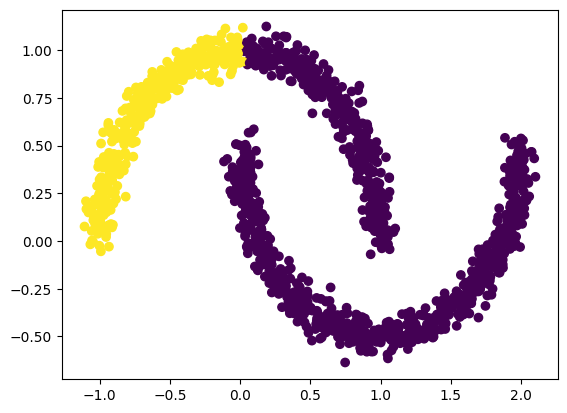

In [22]:
plt.scatter(moons.x, moons.y, c = ac.labels_)

Nuestro modelo tampoco se comporta como esperamos porque existe un hiperparámetro que debemos ajustar. El clustering jerárquico puede utilizar distintos métodos para poder medir la distancia entre clusters y así poder unirlos o no. Evaluemos el funcionamiento de nuestro modelo al visualizar el agrupamiento utilizando los distintos métodos de enlace.

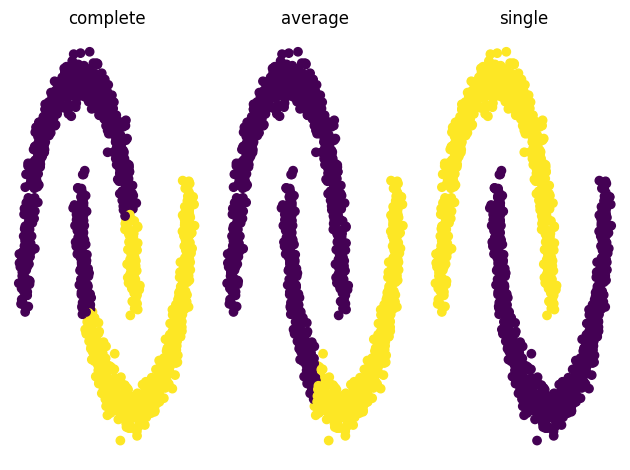

In [23]:
linkage_methods = ["complete", "average", "single"]
fig, axs = plt.subplots(ncols=len(linkage_methods))
for i,l in enumerate(linkage_methods):
    ac_current = sklearn.cluster.AgglomerativeClustering(linkage=l)
    ac_current.fit(moons)
    axs[i].scatter(moons.x, moons.y, c = ac_current.labels_)
    axs[i].set_title(l)
    axs[i].axis('off')
plt.tight_layout()

Para nuestro conjunto de datos el mejor método es single.

In [24]:
ac_tuned = sklearn.cluster.AgglomerativeClustering(linkage="single")
ac_tuned.fit(moons)

AgglomerativeClustering(linkage='single')

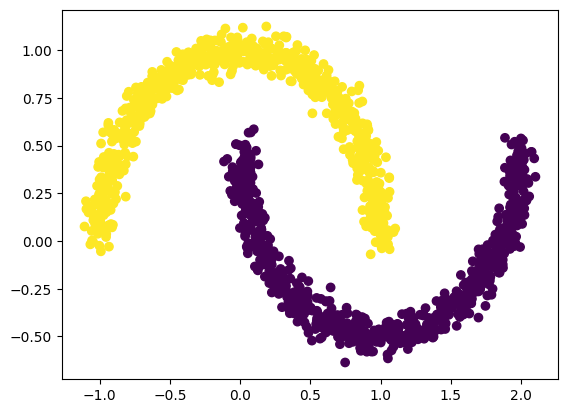

In [25]:
plt.scatter(moons.x, moons.y, c = ac_tuned.labels_)

# Datos de microarreglo

Tenemos un conjunto de datos de expresión génica de genes dentro de distintas lineas celulares. Aplicaremos clustering jerárquico para evaluar qué genes son más cercanos entre sí, como también para evaluar qué lineas celulares son más cercanas entre sí.

In [26]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    scipy.cluster.hierarchy.dendrogram(linkage_matrix, **kwargs)

In [27]:
microarray = pd.read_csv("https://raw.githubusercontent.com/fvillena/biocompu/2021/data/gene_expressions.tsv", sep="\t", index_col="gene", nrows=30)

In [28]:
microarray.head()

,786-0,A498,A549,ACHN,BT-549,CAKI-1,CCRF-CEM,COLO205,DU-145,EKVX,...,SNB-19,SNB-75,SR,SW-620,T-47D,TK-10,U251,UACC-257,UACC-62,UO-31
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,-1.025477,-0.925477,0.274523,-0.875477,2.484523,1.244523,1.914523,-1.025477,0.584523,0.094523,...,0.494523,-0.705477,0.914523,-0.885477,1.524523,-0.995477,0.314523,1.774523,2.104523,-0.665477
A2M,-1.409323,-1.409323,-1.409323,-1.409323,-1.409323,-1.399323,-1.299323,-1.409323,-1.399323,0.100677,...,-0.889323,-0.729323,-1.409323,-1.229323,-1.399323,-1.399323,-1.369323,5.630677,3.280677,-1.399323
A2ML1,-1.696062,-1.686062,-1.686062,-1.686062,-1.696062,-1.696062,-1.696062,-1.696062,-1.696062,-1.586062,...,-1.696062,-1.696062,-1.696062,-1.696062,-1.636062,-1.696062,-1.696062,-1.686062,-1.586062,-1.696062
A4GALT,1.978677,1.588677,0.908677,0.348677,1.098677,1.488677,-1.791323,-1.041323,-0.601323,1.498677,...,0.008677,2.308677,-2.241323,-1.101323,0.668677,-0.181323,-0.131323,-2.241323,-1.581323,1.368677
AAAS,0.878385,0.178385,1.658385,-0.291615,-0.011615,0.568385,1.518385,0.148385,0.158385,1.038385,...,-0.041615,0.638385,0.608385,1.968385,1.218385,0.098385,0.238385,0.778385,0.558385,0.508385


In [29]:
microarray.columns

Index(['786-0', 'A498', 'A549', 'ACHN', 'BT-549', 'CAKI-1', 'CCRF-CEM',
       'COLO205', 'DU-145', 'EKVX', 'HCC-2998', 'HCT-116', 'HCT-15', 'HL-60',
       'HOP-62', 'HOP-92', 'HS-578T', 'HT29', 'IGR-OV1', 'K-562', 'KM12',
       'LOX-IMVI', 'M14', 'MALME-3M', 'MCF7', 'MDA-MB-231', 'MDA-MB-435',
       'MDA-MB-468', 'MOLT-4', 'NCI-ADR-RES', 'NCI-H226', 'NCI-H23',
       'NCI-H322M', 'NCI-H460', 'NCI-H522', 'OVCAR-3', 'OVCAR-4', 'OVCAR-5',
       'OVCAR-8', 'PC-3', 'RPMI-8226', 'RXF-393', 'SF-268', 'SF-295', 'SF-539',
       'SK-MEL-2', 'SK-MEL-28', 'SK-MEL-5', 'SK-OV-3', 'SN12C', 'SNB-19',
       'SNB-75', 'SR', 'SW-620', 'T-47D', 'TK-10', 'U251', 'UACC-257',
       'UACC-62', 'UO-31'],
      dtype='object')

Agrupación por genes

Realizaremos una agrupación a nivel de genes.

In [30]:
ac_microarray = sklearn.cluster.AgglomerativeClustering(linkage='average',distance_threshold=0, n_clusters=None)
ac_microarray.fit(microarray)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

Es probable que genes que se encuentren dentro del mismo cluster puedan tener funciones similares o pertenecer a tejidos similares. Utilizaremos una visualización llamada dendrograma para observar cómo se forman los grupos encontrados.

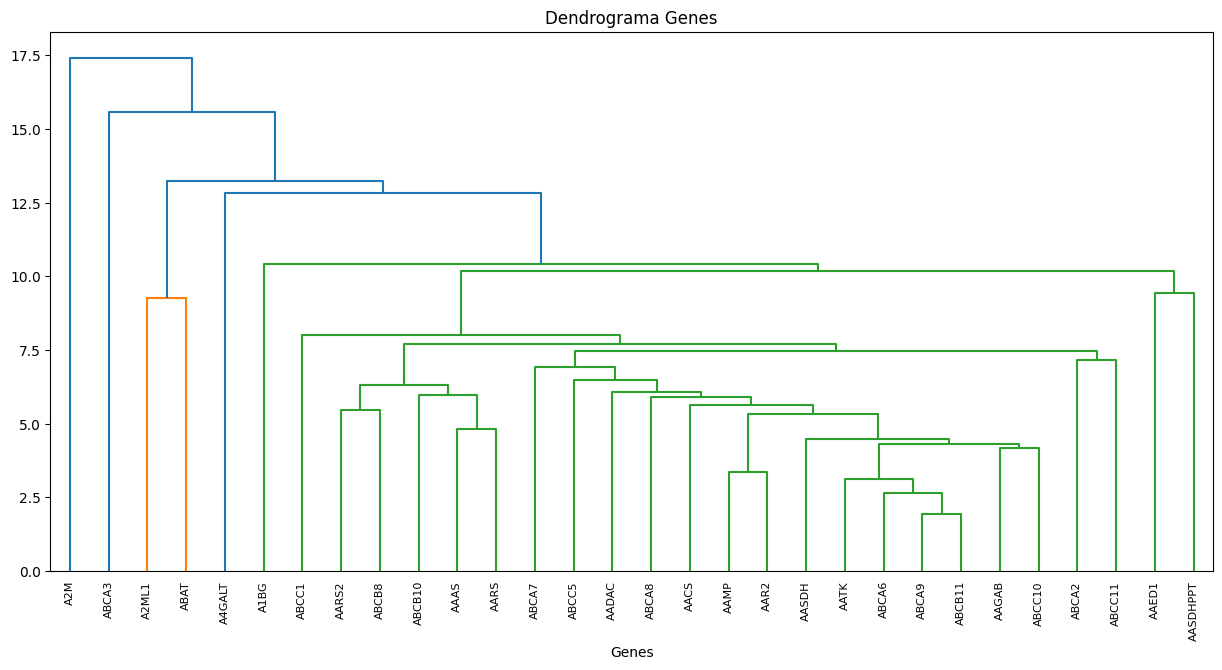

In [31]:
#plot dendrograma genes (para este caso demora por la cantidad de hojas finales)
plt.figure(figsize=(15,7))
plt.title('Dendrograma Genes')
plot_dendrogram(ac_microarray, leaf_rotation=90, leaf_font_size=8, labels=microarray.index)
plt.xlabel("Genes")
plt.show()

Agrupación por líneas celulares

También realizaremos un agrupamiento a nivel de lineas celulares para explorar qué lineas celulares están más cercanas entre sí.

In [32]:
microarray_trans = microarray.transpose()

In [33]:
ac_microarray_trans = sklearn.cluster.AgglomerativeClustering(linkage='average',distance_threshold=0, n_clusters=None)
ac_microarray_trans.fit(microarray_trans)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

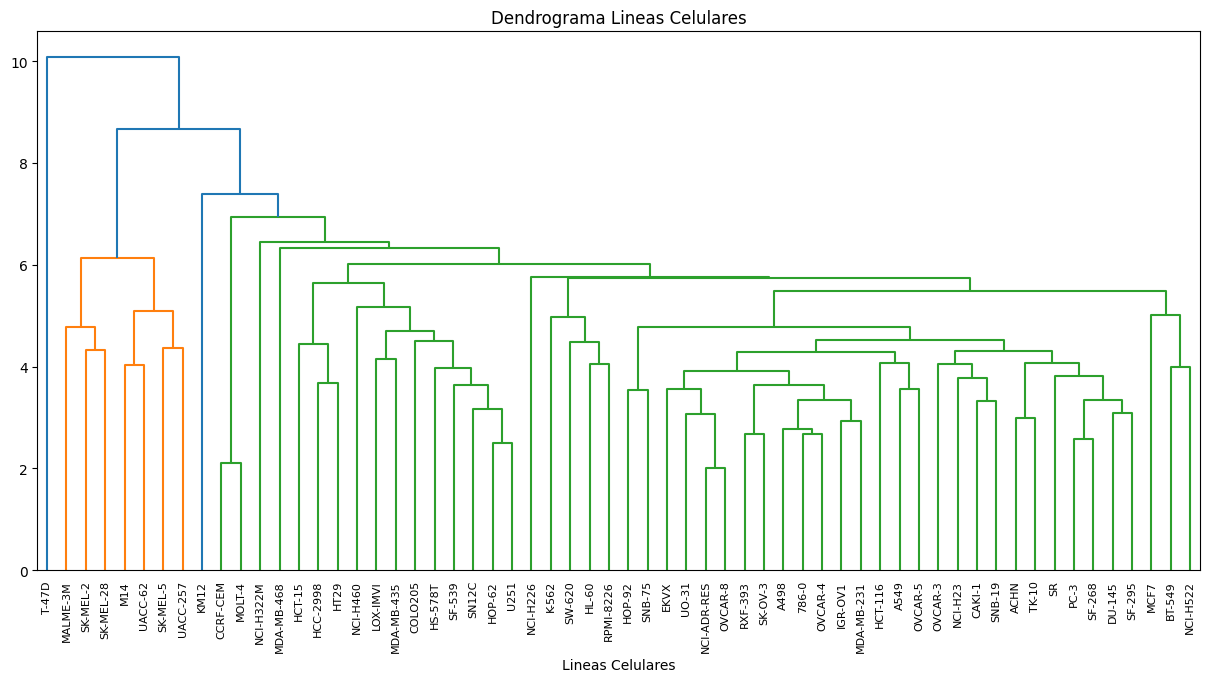

In [34]:
plt.figure(figsize=(15,7))
plt.title('Dendrograma Lineas Celulares')
plot_dendrogram(ac_microarray_trans, leaf_rotation=90, leaf_font_size=8, labels=microarray_trans.index)
plt.xlabel("Lineas Celulares")
plt.show()